<a href="https://colab.research.google.com/github/vasvarym/FakeNewsProject/blob/main/liardatasetwithglove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
import re
import matplotlib.pyplot as plt
# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import nltk
import nltk.corpus
import string
from gensim.models.word2vec import Word2Vec
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

In [2]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [3]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Import dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.tsv to test (1).tsv
Saving train.tsv to train (1).tsv
Saving valid.tsv to valid (1).tsv


In [5]:
def read_file(filename): 
  tain_file = open(filename)
  df = pd.read_csv(tain_file, delimiter="\t", header = None)
  df.rename(columns = {0:'ID', 1:'label', 2:'statement', 3:'subject', 
                           4:'speaker', 5:'job_title', 6:'state', 7:'party', 
                           8:'barely_true_counts', 9:'false_counts', 10:'half_true_counts',
                           11:'mostly_true_counts', 12:'pants_on_fire_counts', 13:'location'}, inplace = True)
  return df

train = read_file('train.tsv')
test = read_file('test.tsv')
valid = read_file('valid.tsv')
train.head()

,ID,label,statement,subject,speaker,job_title,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,location
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
# Shape of each set

print("Shape of TRAIN DATA: ", train.shape)
print("Shape of TEST DATA: ", test.shape)
print("Shape of VALID DATA: ", valid.shape)

Shape of TRAIN DATA:  (10240, 14)
Shape of TEST DATA:  (1267, 14)
Shape of VALID DATA:  (1284, 14)


In [ ]:
# function to check distribution of labels
def check_dist(dataset):
  sns.countplot(x='label', data=dataset, palette='hls')

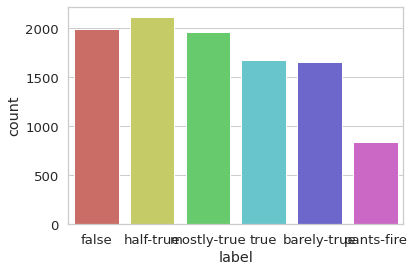

In [ ]:
check_dist(train)

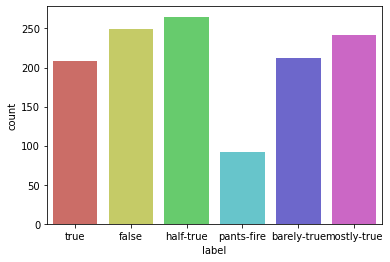

In [ ]:
check_dist(test)

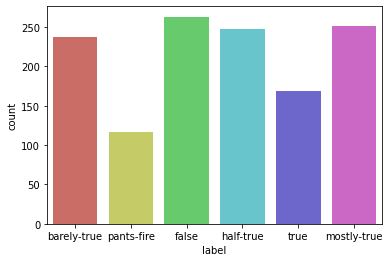

In [ ]:
check_dist(valid)

In [ ]:
# check for missing labels
train.isna().sum()


ID                        0
label                     0
statement                 0
subject                   0
speaker                   0
job_title               345
state                   279
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
location                 12
dtype: int64

In [ ]:
test.isna().sum()

ID                        0
label                     0
statement                 0
subject                   0
speaker                   0
job_title               325
state                   262
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
location                 17
dtype: int64

In [ ]:
valid.isna().sum()

ID                        0
label                     0
statement                 0
subject                   0
speaker                   0
job_title               345
state                   279
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
location                 12
dtype: int64

In [ ]:
train.subject.value_counts()

health-care                                     381
taxes                                           308
immigration                                     253
elections                                       252
education                                       237
                                               ... 
civil-rights,elections,states,transportation      1
public-health,market-regulation,states            1
consumer-safety,government-efficiency             1
federal-budget,history,military                   1
city-government,population                        1
Name: subject, Length: 3827, dtype: int64

In [ ]:
test.subject.value_counts()

health-care                                             40
elections                                               31
education                                               30
candidates-biography                                    30
federal-budget                                          21
                                                        ..
candidates-biography,county-budget,county-government     1
crime,criminal-justice,message-machine-2014,women        1
candidates-biography,crime                               1
education,foreign-policy                                 1
income,small-business,state-budget,taxes                 1
Name: subject, Length: 732, dtype: int64

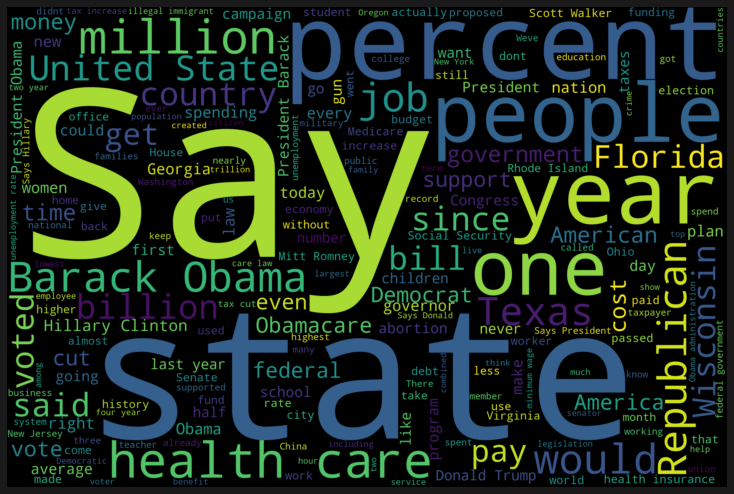

In [ ]:
# WordCloud for test dataset
text = ''
for news in train.statement.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (10, 7.5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [6]:
# drop other columns of the data
def content_only(df):
  new_df = df[['label', 'statement']]
  return new_df

train = content_only(train)
test = content_only(test)
valid = content_only(valid)
train.head()

,label,statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...


In [13]:
# transform labels

def transformLabel(newLabels):
  labels = newLabels.copy()
  for i in range(len(labels)):
    if labels[i] == ('pants-fire'):
      labels[i] = 0.0
    elif labels[i] == 'false':
      labels[i] = 0.0
    elif labels[i] == 'barely-true':
      labels[i] = 0.0
    elif labels[i] == 'true':
      labels[i] = 1.0
    elif labels[i] == 'mostly-true':
      labels[i] = 1.0
    else:
      labels[i] = 0.0
  labels = np.asarray(labels).astype('float32')
  return labels

# Text Pre-Processing

In [14]:
def rem_noise(text):
  text = text.translate(str.maketrans('','',string.punctuation))

  text =  re.sub('[0-9]+','',text)

  text = re.sub('https?:\S+','',text)

  text =  re.sub('<.*?>'," ",text)

  return text

In [15]:
stop = set(stopwords.words('english'))

def rem_stopwords(text):
    
    words = [ch for ch in text if ch not in stop]
    words= "".join(words).split()
    words= [words.lower() for words in text.split()]
    
    return words   

In [16]:
def tokenize_statements(text):
    
    # Tokenize the words
    tokenized = word_tokenize(text)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words, changing text to lowercase
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token.lower(), pos='a') for token in tokenized]
    
    return tokenized

# TFIDF

In [ ]:
# Creating X and Y test
X_train = train["statement"].apply(rem_noise)
X_test = test["statement"].apply(rem_noise)
X_valid = valid["statement"].apply(rem_noise)

In [ ]:
label_train = train["label"]
label_test = test["label"]
label_valid = valid["label"]

In [ ]:
y_train = transformLabel(label_train)
y_test = transformLabel(label_test)
y_valid = transformLabel(label_valid)

In [ ]:
# Apply text pre-processing, then vectorize the text so the models can actually interpret it
vectorizer = TfidfVectorizer(tokenize_statements)
x_train_vectorized = vectorizer.fit_transform(X_train)
x_test_vectorized = vectorizer.transform(X_test)

In [ ]:
print(x_train_vectorized)

NameError: ignored

In [ ]:
print (x_train_vectorized.shape)
print (x_test_vectorized.shape)
print (y_train.shape)
print (y_test.shape)

(10240, 11179)
(1267, 11179)
(10240,)
(1267,)


# Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(x_train_vectorized, y_train)
logR_predicted = log_reg.predict(x_test_vectorized)
print(f"{log_reg.__class__.__name__} accuracy: {log_reg.score(x_test_vectorized, y_test)}")

LogisticRegression accuracy: 0.6535122336227308


In [ ]:
print(classification_report(y_test, logR_predicted))
print('\n')
print(confusion_matrix(y_test, logR_predicted))

              precision    recall  f1-score   support

         0.0       0.67      0.90      0.77       818
         1.0       0.53      0.21      0.30       449

    accuracy                           0.65      1267
   macro avg       0.60      0.55      0.53      1267
weighted avg       0.62      0.65      0.60      1267



[[734  84]
 [355  94]]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(log_reg, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

0.6521484375

# Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=10, max_depth=100)
random_forest.fit(x_train_vectorized, y_train)

print(f"{random_forest.__class__.__name__} accuracy: {random_forest.score(x_test_vectorized, y_test)}")

NameError: ignored

In [ ]:
rForest_pred = random_forest.predict(x_test_vectorized)
print(classification_report(y_test, rForest_pred))
print('\n')
print(confusion_matrix(y_test, rForest_pred))

NameError: ignored

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(random_forest, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

# Multinomial Naive Bayes

In [ ]:
multi_nb = MultinomialNB()
multi_nb.fit(x_train_vectorized, y_train)
print(f"{multi_nb.__class__.__name__} accuracy: {multi_nb.score(x_test_vectorized, y_test)}")

MultinomialNB accuracy: 0.6203125


In [ ]:
NaiveB_pred = multi_nb.predict(x_test_vectorized)
print(classification_report(y_test, NaiveB_pred))
print('\n')
print(confusion_matrix(y_test, NaiveB_pred))

              precision    recall  f1-score   support

       False       0.59      0.29      0.39      1065
        True       0.63      0.85      0.72      1495

    accuracy                           0.62      2560
   macro avg       0.61      0.57      0.56      2560
weighted avg       0.61      0.62      0.59      2560



[[ 312  753]
 [ 219 1276]]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(multi_nb, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

#SVM

In [ ]:
svm = svm.LinearSVC()
svm.fit(x_train_vectorized, y_train)
print(f"{svm.__class__.__name__} accuracy: {svm.score(x_test_vectorized, y_test)}")

LinearSVC accuracy: 0.6053670086819258


In [ ]:
svm_pred = svm.predict(x_test_vectorized)

print(classification_report(y_test, svm_pred))
print('\n')
print(confusion_matrix(y_test, svm_pred))

              precision    recall  f1-score   support

       False       0.50      0.48      0.49      1065
        True       0.64      0.66      0.65      1495

    accuracy                           0.59      2560
   macro avg       0.57      0.57      0.57      2560
weighted avg       0.58      0.59      0.58      2560



[[509 556]
 [506 989]]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(svm, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

# LSTM with GloVe embedding

In [9]:
df_lstm = pd.concat([train,test,valid])

In [10]:
df_lstm

,label,statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...
...,...,...
1279,half-true,"For the first time in more than a decade, impo..."
1280,mostly-true,Says Donald Trump has bankrupted his companies...
1281,true,"John McCain and George Bush have ""absolutely n..."
1282,false,A new poll shows 62 percent support the presid...


In [18]:
glovedf = df_lstm.reset_index(drop=True)

In [19]:
cleantext = glovedf['statement'].apply(rem_noise)
cleantext = cleantext.apply(rem_stopwords)
y_label = glovedf["label"]

In [20]:
cleantext

0        [says, the, annies, list, political, group, su...
1        [when, did, the, decline, of, coal, start, it,...
2        [hillary, clinton, agrees, with, john, mccain,...
3        [health, care, reform, legislation, is, likely...
4        [the, economic, turnaround, started, at, the, ...
                               ...                        
12786    [for, the, first, time, in, more, than, a, dec...
12787    [says, donald, trump, has, bankrupted, his, co...
12788    [john, mccain, and, george, bush, have, absolu...
12789    [a, new, poll, shows, percent, support, the, p...
12790    [no, one, claims, the, report, vindicating, ne...
Name: statement, Length: 12791, dtype: object

In [21]:
y_transformed = transformLabel(y_label)

y_transformed

array([0., 0., 1., ..., 1., 0., 0.], dtype=float32)

In [22]:
x = cleantext.values
y = y_transformed

In [23]:
from keras.preprocessing import text, sequence

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
word_to_index = tokenizer.word_index
contentSequence = tokenizer.texts_to_sequences(x)

In [25]:
vocab_size =  len(word_to_index)
oov_tok = "<OOV>"
max_length = 250
embedding_dim = 100

In [26]:
from keras.preprocessing.sequence import pad_sequences

contentSequence = pad_sequences(contentSequence, maxlen=max_length)

In [27]:
contentSequence

array([[   0,    0,    0, ...,  532,   11, 1668],
       [   0,    0,    0, ...,  620, 1050,  168],
       [   0,    0,    0, ..., 3823,   11,  369],
       ...,
       [   0,    0,    0, ..., 1398,   30,   40],
       [   0,    0,    0, ...,   30,  115,   90],
       [   0,    0,    0, ..., 2166,   10, 7444]], dtype=int32)

In [33]:
contentSequence.shape

(12791, 250)

# GloVe embeddings

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# load the whole embedding into memory

embeddings_index = {};
with open('/content/drive/My Drive/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

# create a weight matrix for words

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [30]:
embeddings_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [ 0.085703  , -0.22201   ,  0.16569   , ..., -0.074273  ,
         0.75808001, -0.34243   ],
       ...,
       [ 0.088572  , -0.39976001,  0.87237   , ...,  0.58825999,
         0.80910999, -0.14996   ],
       [ 0.43285   , -0.14575   ,  0.034812  , ...,  0.57229   ,
        -0.62256002, -0.39954999],
       [-0.088947  , -0.44319001,  0.39702001, ...,  0.045105  ,
        -0.26666   ,  0.30891001]])

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(contentSequence,y,test_size=0.20,random_state=1)

In [32]:
y_train

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

# Defining Neural Network

In [34]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size+1, output_dim=embedding_dim, weights=[embeddings_matrix], input_length=max_length, trainable=False))
#LSTM 
model.add(LSTM(units=128, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#del embeddings_matrix

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          1382800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,500,177
Trainable params: 117,377
Non-trainable params: 1,382,800
_________________________________________________________________


In [36]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test) , epochs=5)

Epoch 1/5
320/320 [==============================] - 83s 254ms/step - loss: 0.6495 - accuracy: 0.6315 - val_loss: 0.6268 - val_accuracy: 0.6573
Epoch 2/5
320/320 [==============================] - 81s 253ms/step - loss: 0.6315 - accuracy: 0.6540 - val_loss: 0.6249 - val_accuracy: 0.6491
Epoch 3/5
320/320 [==============================] - 82s 255ms/step - loss: 0.6207 - accuracy: 0.6602 - val_loss: 0.6271 - val_accuracy: 0.6592
Epoch 4/5
320/320 [==============================] - 82s 256ms/step - loss: 0.6027 - accuracy: 0.6752 - val_loss: 0.6235 - val_accuracy: 0.6460
Epoch 5/5
320/320 [==============================] - 82s 257ms/step - loss: 0.6022 - accuracy: 0.6693 - val_loss: 0.6266 - val_accuracy: 0.6542


Evaluate the model on the test set

In [77]:
y_pred_glove = (model.predict(X_test) > 0.5).astype("int")

In [78]:
print("Accuracy is {} for LSTM with GloVe embedding.".format(accuracy_score(y_test, y_pred_glove)))

Accuracy is 0.6611957796014069 for LSTM with GloVe embedding.


In [79]:
print(classification_report(y_test, y_pred_glove, zero_division = 1))

              precision    recall  f1-score   support

         0.0       0.67      0.94      0.79      1687
         1.0       0.51      0.11      0.18       872

    accuracy                           0.66      2559
   macro avg       0.59      0.53      0.49      2559
weighted avg       0.62      0.66      0.58      2559



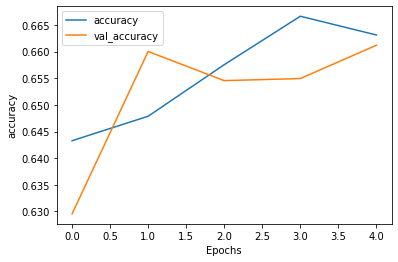

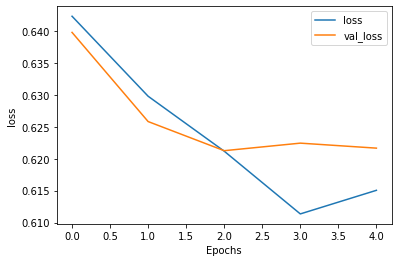

In [80]:
#plot accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")